In [72]:
import itertools
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl
from IPython import display
%matplotlib inline

## GAN Simulations

This notebook is a sandbox for running small-scale simulations and demonstrations for [Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661).  

### 0.  Base Model

Let's first define some basic neural networks in Tensorflow...

In [2]:
def init_neural_net(layer_sizes, std=.1):
    params = {'w':[], 'b':[]}
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        params['w'].append(tf.Variable(tf.random_normal([n_in, n_out], stddev=std)))
        params['b'].append(tf.Variable(tf.zeros([n_out,])))
    return params

def neural_net(X, params):
    h = [X]
    for w,b in zip(params['w'][:-1], params['b'][:-1]):
        h.append( tf.nn.relu( tf.matmul(h[-1], w) + b ) )
    return tf.matmul(h[-1], params['w'][-1]) + params['b'][-1]

### 1.  Gaussian Mixture Simulation
This demo uses data generated from a Gaussian mixture model.  First, let's make a function to simulate the data...

In [3]:
# Draw sample from mixture model
# k ~ Mult(pi)
# z ~ f_k
def draw_samples(pi_arr, mu_arr, cov_arr, n_samples=100):
    comp_arr = np.random.multinomial(n_samples, pi_arr)
    z = []
    for idx, count in enumerate(comp_arr):
        for c in xrange(count):
            z.append(np.random.multivariate_normal(mu_s[idx], cov_s[idx]))
    return np.array(z)

Create the data and symbolic variables...

In [4]:
N = 300 # number of datapoints 
latent_size = 50
vis_size = 2
hidden_size = 500
learning_rate = .05

### Generate True Distribution
pi = np.array([.35, .65])
# define base dists.
mu_s = [np.array([-5., -5.]), np.array([5., 5.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]
# draw_samples
X_true = draw_samples(pi, mu_s, cov_s, N)

### Make symbolic variables
Z = tf.placeholder("float", [None, latent_size]) # latent features sampled from prior
X = tf.placeholder("float", [None, vis_size]) # samples to discriminate
Y = tf.placeholder("float", [None, 1]) # labels

Define the discriminator model...

In [5]:
discrim_params = init_neural_net([vis_size, hidden_size, 1]) 
discrim_out = neural_net(X, discrim_params)

discrim_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(discrim_out, Y))
train_discriminator = tf.train.GradientDescentOptimizer(learning_rate).minimize(discrim_cost, var_list=discrim_params['w']+discrim_params['b'])

Define the generator model...

In [6]:
generator_params = init_neural_net([latent_size, hidden_size, vis_size])
generator_out = neural_net(Z, generator_params)
discrim_out_genUpdate = neural_net(generator_out, discrim_params)

generator_cost = tf.reduce_mean(-tf.nn.sigmoid_cross_entropy_with_logits(discrim_out_genUpdate, Y))
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Let's train...

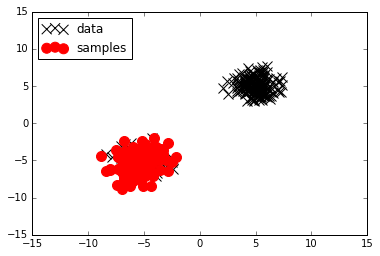

In [7]:
def shuffle_in_unison_inplace(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

def plot_densities(true_data, samples):
    # clear the plot
    display.clear_output(wait=True)

    plt.scatter(true_data[:,0], true_data[:,1], s=100, color='k', marker='x', label="data")
    plt.scatter(samples[:,0], samples[:,1], s=100, color='r', marker='o', label="samples")
    plt.legend(loc=2)
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.show()

# Make labels for training
Y_true = np.ones((N, 1))
Y_gen = np.zeros((N,1))
Y_concat = np.vstack([Y_true, Y_gen])

# Set training params
n_epochs = 150
n_discrim_updates = 10
n_generator_updates = 3

generator_weights = None
generator_biases = None
with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        discrim_error = 0.
        for idx in xrange(n_discrim_updates):
            # sample from generator
            prior_samples = np.random.normal(size=(N, latent_size))
            genSamples = session.run(generator_out, feed_dict={Z: prior_samples})
        
            # make dataset and shuffle
            train_X = np.vstack([X_true, genSamples])
            train_X, train_Y = shuffle_in_unison_inplace(train_X, Y_concat)
        
            # perform update
            _, l = session.run([train_discriminator, discrim_cost], feed_dict={X: train_X, Y: train_Y})
            discrim_error += l
        # print "Epoch %d.  Discriminator error: %.3f" %(epoch_idx, discrim_error)
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples = np.random.normal(size=(N, latent_size))
        
            # perform update
            session.run(train_generator, feed_dict={Z: prior_samples, Y: Y_gen})
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_true, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_size))}))
        
    # save the generator params
    generator_weights = [session.run(w) for w in generator_params['w']]
    generator_biases = [session.run(b) for b in generator_params['b']]

The GAN can capture one mode well but not both (at least for the settings I've tried).  This is known problem: "A common problem with GAN framework is that the generator tends to only generate samples that are clustered in one or a few modes of the regions of high data density, instead of spanning the whole range" [[source]](https://arxiv.org/pdf/1609.03126v2.pdf).

### 2.  A Discriminator Based on Importance Weights
Classification error isn't the only way to define the discriminator model, as Ferenc discusses [here](http://www.inference.vc/are-energy-based-gans-actually-energy-based/).  Another objective he mentions is defined through model-based importance weight estimation, which can be written $$ w(\mathbf{x}) = \frac{q(\mathbf{x})}{p(\mathbf{x})} \approx \boldsymbol{\alpha}^{T} \phi(\mathbf{x}) = \hat{w}(\mathbf{x}) $$ where $p$ and $q$ are two distributions, $\alpha \ge 0$ is a vector of coefficients (to be learned), and $\phi(\mathbf{x}) \ge 0$ is a non-negative basis function.  We can simply transform the network output by the ReLU function to ensure it's strictly positive.  [Kanamori et al.](http://www.jmlr.org/papers/volume10/kanamori09a/kanamori09a.pdf) then show that $$\frac{1}{2} \mathbb{E}_{p}[(\hat{w}(\mathbf{x}) - w(\mathbf{x}))^{2}] = \frac{1}{2} \mathbb{E}_{p}[\hat{w}(\mathbf{x})^{2}] -  \int \hat{w}(\mathbf{x})q(\mathbf{x}) d\mathbf{x} + \frac{1}{2} \mathbb{E}_{p}[w(\mathbf{x})^{2}]  \propto  \frac{1}{2} \mathbb{E}_{p}[\hat{w}(\mathbf{x})^{2}] - \mathbb{E}_{q}[\hat{w}(\mathbf{x})].$$  We can think of $p$ as being the true data distribution from which we have samples and $q$ as our generator model.  Q: does a similar objective exist for [Fisher Score Matching](https://www.cs.helsinki.fi/u/ahyvarin/papers/JMLR05.pdf)?  FSM has some robust properties that may improve or stabilize training.    

We now will implement the above cost, replacing the classification cost.  First, let's define the model hyperparameters, the optimization hyperparameters, and the symbolic variables...

In [8]:
N = 300 # number of datapoints 
latent_size = 50
vis_size = 2
hidden_size = 500
learning_rate = .01

# Make symbolic variables
Z = tf.placeholder("float", [None, latent_size]) # latent features sampled from prior
X_p = tf.placeholder("float", [None, vis_size]) # true data
X_q = tf.placeholder("float", [None, vis_size]) # samples from generator
# no need for labels

Let's implement the importance weight objective in the discriminator...

In [9]:
discrim_out_p = neural_net(X_p, discrim_params)
discrim_out_q = neural_net(X_q, discrim_params)

discrim_cost = tf.reduce_mean(.5*tf.pow(discrim_out_p, 2)) - tf.reduce_mean(tf.nn.relu(discrim_out_q))
train_discriminator = tf.train.GradientDescentOptimizer(learning_rate).minimize(discrim_cost, var_list=discrim_params['w']+discrim_params['b'])

Make the corresponding changes to the generator...

In [10]:
generator_out = neural_net(Z, generator_params)
discrim_out_genUpdate = neural_net(generator_out, discrim_params)

generator_cost = tf.reduce_mean(tf.nn.relu(discrim_out_genUpdate))
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Let's train...

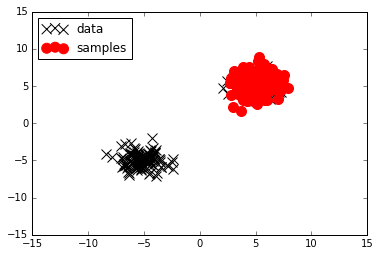

In [11]:
# Set training params
n_epochs = 150
n_discrim_updates = 10
n_generator_updates = 3

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        discrim_error = 0.
        for idx in xrange(n_discrim_updates):
            # sample from generator
            prior_samples = np.random.normal(size=(N, latent_size))
            genSamples = session.run(generator_out, feed_dict={Z: prior_samples})
        
            # perform update
            _, l = session.run([train_discriminator, discrim_cost], feed_dict={X_p: X_true, X_q: genSamples})
            discrim_error += l
        # print "Epoch %d.  Discriminator error: %.3f" %(epoch_idx, discrim_error)
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples = np.random.normal(size=(N, latent_size))
        
            # perform update
            session.run(train_generator, feed_dict={Z: prior_samples})
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_true, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_size))}))

### 3.  Is Joint Training Necessary?
Much of the instability and difficulty in GAN training is a result of the inner-vs-outter-loop adversarial process.  Yet, is this joint training procedure necessary if all we need is a model that provides a 'goodness-of-fit' value?  If we have a pre-trained discriminator that already knows which data regions should have low density, why not optimize the generator based on that?  Let's examine this question for the Gaussian mixture example.

Again, let's first define the model hyperparameters, the optimization hyperparameters, and the symbolic variables...

In [12]:
N = 300 # number of datapoints 
latent_size = 50
vis_size = 2
hidden_size = 500
learning_rate = .01

# Gauss MM params
discrim_params = {
    'mu': [tf.constant([-5.,-5.]), tf.constant([5.,5.])],
    'pi': [tf.constant(.35), tf.constant(.65)]
}

# Make symbolic variables
Z = tf.placeholder("float", [None, latent_size]) # latent features sampled from prior
# No need for true data since we'll assume we have access to the model

Next, let's make the Gaussian M.M. in Tensorflow...

In [13]:
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi)) * tf.exp(-.5 * tf.reduce_sum(tf.pow(x-params['mu'],2),1))

def gaussMixPDF(x, params):
    return params['pi'][0]*gaussPdf(x,{'mu':params['mu'][0]}) + params['pi'][1]*gaussPdf(x,{'mu':params['mu'][1]})

Make the appropriate changes to the generator...

In [14]:
generator_params = init_neural_net([latent_size, hidden_size, vis_size])
generator_out = neural_net(Z, generator_params)
discrim_out_genUpdate = gaussMixPDF(generator_out, discrim_params)

generator_cost = tf.reduce_mean(-tf.log(discrim_out_genUpdate)) 
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Let's train...

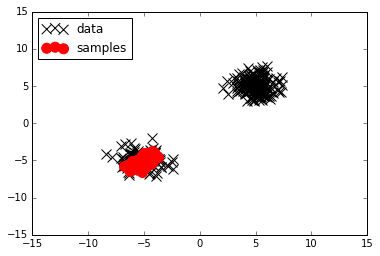

In [17]:
# Set training params
n_epochs = 150
n_generator_updates = 3

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        # NO NEED, HAVE ACCESS TO GENERATIVE PROCESS
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples = np.random.normal(size=(N, latent_size))
        
            # perform update
            session.run(train_generator, feed_dict={Z: prior_samples})
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_true, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_size))}))

This works okay, but it seems to be very mode seeking, which makes sense since the generator is not rewarded for exploring the whole space.  Let's try to fix this.

### 4.  A Diversity Penalty
Let's try to improve the mass-covering ability of the generator network by adding a simple regularization penalty of the form $$\mathcal{R} = \sum_{i=1}^{N} \sum_{j=1, j \ne i}^{N} k(x_{i}, x_{j}) $$ where $k(\cdot, \cdot)$ is a valid kernel (such as the RBF).  Since this operation is $DN^{2}$, we can approximate the sum by not using all pair combinations.

Add this term to the generator...

In [35]:
# usual terms
generator_params = init_neural_net([latent_size, hidden_size, vis_size])
generator_out = neural_net(Z, generator_params)
discrim_out_genUpdate = gaussMixPDF(generator_out, discrim_params)

# regularization
diversity_weight = 15.
def rbf_kernel(x1, x2, l=1.):
    return tf.exp(-.5/l * tf.reduce_sum(tf.pow(x1 - x2,2),1) )

Z_reg = tf.placeholder("float", [None, latent_size]) # extra samples for regularization term
generator_out_Reg = neural_net(Z_reg, generator_params)
kernel_Reg = rbf_kernel(generator_out, generator_out_Reg)

generator_cost = tf.reduce_mean(-tf.log(discrim_out_genUpdate) + diversity_weight*kernel_Reg) 
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Let's train...

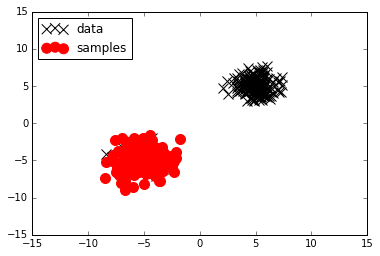

In [36]:
# Set training params
n_epochs = 150
n_generator_updates = 3

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        # NO NEED, HAVE ACCESS TO GENERATIVE PROCESS
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples1 = np.random.normal(size=(N, latent_size))
            prior_samples2 = np.random.normal(size=(N, latent_size))
        
            # perform update
            session.run(train_generator, feed_dict={Z: prior_samples1, Z_reg: prior_samples2})
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_true, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_size))}))

### 5.  Two-Step Training of DAE-to-Generator on MNIST
Let's try the two-step training process on a subset of MNIST...

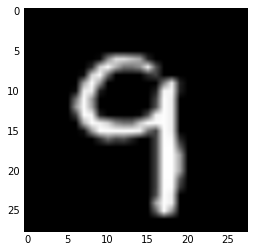

In [100]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

# reduce dataset and normalize to [0,1]
random_idxs = range(mnist.data.shape[0])
shuffle(random_idxs)
mnist_images = mnist.data[random_idxs[:25000],:] / 255.

# show the first image
plt.imshow(np.reshape(mnist_images[0,:] * 255., (28, 28)), cmap='Greys_r')
plt.show()

First we need a model that can tell us if a sample is probable or not.  Let's use a denoising autoencoder for that.  First define the hyperparameters...

In [101]:
N, vis_size = mnist_images.shape # number of datapoints 
hidden_size = 500
learning_rate = .01

# Make symbolic variables
X = tf.placeholder("float", [None, vis_size]) # images

Now define the DAE model with Dropout noise...

In [81]:
dae_params = init_neural_net([vis_size, hidden_size, vis_size])
X_dropped = tf.nn.dropout(X, .5)
dae_out = neural_net(X_dropped, dae_params)

dae_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(dae_out, X)) 
train_dae = tf.train.GradientDescentOptimizer(learning_rate).minimize(dae_cost, var_list=dae_params['w']+dae_params['b'])

Train the DAE (takes 15 mins or so)...

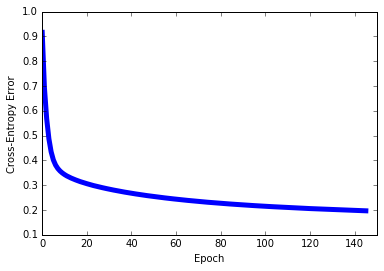

In [82]:
# Set training params
n_epochs = 150
batch_size = 100
n_batches = N/batch_size

loss_tracker = []
dae_weights = None
dae_biases = None

with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    for epoch_idx in xrange(n_epochs):
        epoch_loss = 0.
        for batch_idx in xrange(n_batches):
            _, l = session.run([train_dae, dae_cost], feed_dict={X: mnist_images[batch_idx*batch_size:(batch_idx+1)*batch_size, :]})
            epoch_loss += l
        loss_tracker.append(epoch_loss/n_batches)
    
        if epoch_idx%5 == 0:
            # show the optimization progress
            display.clear_output(wait=True)
            plt.plot(range(n_epochs), loss_tracker + [np.nan]*(n_epochs-epoch_idx-1), linewidth=5)
            plt.xlim(0,n_epochs)
            plt.xlabel("Epoch")
            plt.ylabel("Cross-Entropy Error")
            plt.show()
            
    # save the DAE params
    dae_weights = [session.run(w) for w in dae_params['w']]
    dae_biases = [session.run(b) for b in dae_params['b']]

Now define a generator network (with kernel-based diversity regularization) using the DAE for guidance...

In [157]:
hidden_size = 500
learning_rate = .00000000001
latent_size = 100

# make dae parameters constant
dae_params = {'w':[tf.constant(w) for w in dae_weights], 'b':[tf.constant(b) for b in dae_biases]}

# generator network
Z = tf.placeholder("float", [None, latent_size]) # latent features sampled from prior
generator_params = init_neural_net([latent_size, hidden_size, vis_size])
generator_out = neural_net(Z, generator_params)
generator_out_squashed = tf.nn.sigmoid(generator_out)
discrim_out_genUpdate = neural_net(generator_out_squashed, dae_params)

# regularization
diversity_weight = .0
Z_reg = tf.placeholder("float", [None, latent_size]) # extra samples for regularization term
generator_out_Reg = neural_net(Z_reg, generator_params)
kernel_Reg = rbf_kernel(generator_out, generator_out_Reg)

# compose DAE loss and generator regularization
dae_cost_forGen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(discrim_out_genUpdate, generator_out_squashed), 1)
generator_cost = tf.reduce_mean(dae_cost_forGen) #+ diversity_weight*kernel_Reg) 
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Train the generator...

In [ ]:
# Set training params
n_epochs = 150

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        epoch_loss = 0.
        
        # sample from prior
        prior_samples = np.random.normal(size=(N, latent_size))
        aux_samples = np.random.normal(size=(N, latent_size))
            
        for batch_idx in xrange(n_batches):
            # perform update
            _, l, g, d = session.run([train_generator, generator_cost, generator_out_squashed, discrim_out_genUpdate ], feed_dict={Z: prior_samples[batch_idx*batch_size:(batch_idx+1)*batch_size],
                                                                             Z_reg: aux_samples[batch_idx*batch_size:(batch_idx+1)*batch_size]})
            epoch_loss += l
            print g
            print
            print d
            
        print epoch_loss / n_batches
        
        # visualize a sample to gauge progress
        if epoch_idx==-1: #%5 == 0: 
            mnist_sample = session.run(generator_out_squashed, feed_dict={Z:np.random.normal(size=(1, latent_size))})
            display.clear_output(wait=True)
            plt.imshow(np.reshape(mnist_sample * 255., (28, 28)), cmap='Greys_r')
            plt.show()